# Recommender systems

People's tastes vary, but generally follow patterns. People tend to like things that are similar to other things they like, and they tend to have similar taste as other people they are close with. Recommender systems try to capture these patterns to help predict what else people might like.

Data: http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [106]:
import pandas as pd
import numpy as np

header = ['user_id', 'item_id', 'rating', 'timestamp']
data = pd.read_csv('ml-100k/u.data', sep = '\t', names = header)

# Get unique users and movies
n_users = data.user_id.unique().shape[0]
n_items = data.item_id.unique().shape[0]
print 'Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items)

Number of users = 943 | Number of movies = 1682


## Recommender systems fall into a number of different categories:

    1.) Collaborative filtering:
        1.1.) Memory-Based Collaborative filtering
        1.2.) Model-Based Collaborative filtering
    2.) Content-based approach  
    3.) Hybrid models (CF + Content-based approach)

### 1.) Collaborative filtering

Collaborative filtering methods make use of users’ past behaviour in order to recommend items. Ex: If Jack loves A and B, and Jill loves A, B, and C, then Jack is more likely to love C. The task is to discover patterns in observed preference behaviour (e.g. purchase history) and predict new preferences based on those patterns. This approach does not rely on on item or user attributes.

#### 1.1.) Memory-Based collaborative filtering

Memory-Based Collaborative Filtering approaches (Neighbourhood-based) can be divided into two main sections: user-item filtering and item-item filtering. A user-item filtering takes a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. In contrast, item-item filtering will take an item, find users who liked that item, and find other items that those users or similar users also liked. In both cases, you create a user-item matrix which is often sparse. This is an important detail because, when dealing with very large data sets, storing them into appropriate data structures can help us significantly increase computation time.

    1.1.1.) User-item filtering: “Users who are similar to you also liked …”
    1.1.2.) Item-item filtering: “Users who liked this item also liked …”

We treat either the columns (items) or rows (users) as vectors. We can measure the distance between 
these vectors using various measures of similarity or distance. 

##### Measures of distance or similarity:  
    a.) Euclidean Distance  
    b.) Pearson Correlation
    c.) Cosine Similarity

The user-itam matrix is sparse. Sparsity = 93.70%


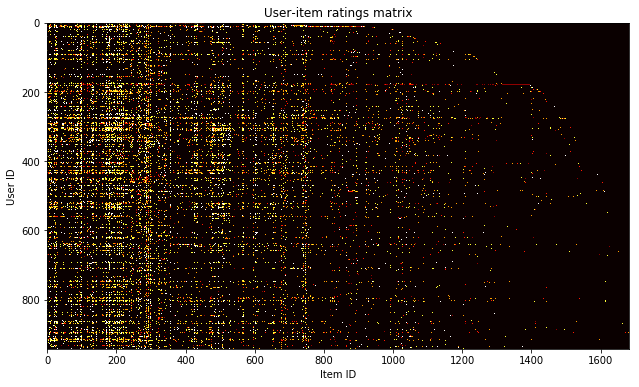

In [107]:
import matplotlib.pyplot as plt

# Create empty user-item matrix
u_i_matrix = np.zeros((n_users, n_items))

# Populate user-item matrix
for line in data.itertuples():
    u_i_matrix[line[1]-1, line[2]-1] = line[3]

#Print sparsity
sparsity = float(len(u_i_matrix.nonzero()[0]))/(u_i_matrix.shape[0] * u_i_matrix.shape[1])
print 'The user-itam matrix is sparse. Sparsity = {:4.2f}%'.format((1-sparsity)*100)

# Plot u_i_matrix
plt.figure(figsize = (14, 6))
plt.imshow(u_i_matrix, cmap='hot', interpolation='nearest')
plt.title('User-item ratings matrix')
plt.ylabel('User ID')
plt.xlabel('Item ID')
plt.show()

To split the data into training and test sets, we remove 10 ratings per user from the training set and place them in the test set.

In [108]:
def train_test_split(u_i_matrix):
    test = np.zeros(u_i_matrix.shape)
    train = u_i_matrix.copy()
    for user in xrange(u_i_matrix.shape[0]):
        test_ratings = np.random.choice(u_i_matrix[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = u_i_matrix[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0))
    return train, test

train, test = train_test_split(u_i_matrix)

Create a function to calculate similarities:

In [109]:
from sklearn.metrics.pairwise import pairwise_distances

def calc_similarity(matrix, kind, metric):
    if kind == 'user':
        if metric == 'cosine':
            user_similarity = 1-pairwise_distances(matrix, metric = metric)
        else:
            user_similarity = pairwise_distances(matrix, metric = metric)
        return user_similarity
    elif kind == 'item':
        if metric == 'cosine':
            item_similarity = 1-pairwise_distances(matrix.T, metric = metric)
        else:
            item_similarity = pairwise_distances(matrix.T, metric = metric)
        return item_similarity

user_similarity_scikit = calc_similarity(train, 'user', 'cosine')
item_similarity_scikit = calc_similarity(train, 'item', 'cosine')

print user_similarity_scikit[:4, :4]

[[1.         0.17990531 0.04258809 0.07003755]
 [0.17990531 1.         0.05482446 0.20352936]
 [0.04258809 0.05482446 1.         0.14118189]
 [0.07003755 0.20352936 0.14118189 1.        ]]


In [110]:
def fast_similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [111]:
user_similarity = fast_similarity(train, kind='user')
item_similarity = fast_similarity(train, kind='item')

With the similarity matrix calculated, we can now predict the ratings that were not included with the data. Using these predictions, we can then compare them with the test data to attempt to validate the quality of our recommender model.

For user-based collaborative filtering, we predict that a user's u's rating for item i is given by the weighted sum of all other users' ratings for item i where the weighting is the cosine similarity between the each user and the input user u.

In [112]:
from  sklearn.metrics import mean_squared_error

def predict(u_i_matrix, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(u_i_matrix) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return u_i_matrix.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [113]:
item_prediction = predict(train, item_similarity_scikit, kind='item')
user_prediction = predict(train, user_similarity_scikit, kind='user')

print 'User-based CF MSE: ' + str(get_mse(user_prediction, test))
print 'Item-based CF MSE: ' + str(get_mse(item_prediction, test))

User-based CF MSE: 8.440444485289454
Item-based CF MSE: 11.581344006729775


We can attempt to improve our prediction MSE by only considering the top k users who are most similar to the input user (or, similarly, the top k items)

In [114]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in xrange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in xrange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in xrange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [115]:
pred = predict_topk(train, user_similarity_scikit, kind='user', k=40)
print 'Top-k User-based CF MSE: ' + str(get_mse(pred, test))

pred = predict_topk(train, item_similarity_scikit, kind='item', k=40)
print 'Top-k Item-based CF MSE: ' + str(get_mse(pred, test))

Top-k User-based CF MSE: 6.55999948740044
Top-k Item-based CF MSE: 7.761041230873171


Memory-based algorithms are easy to implement and produce reasonable prediction quality. The drawback of memory-based CF is that it doesn't scale to real-world scenarios and doesn't address the well-known cold-start problem, that is when new user or new item enters the system. Model-based CF methods are scalable and can deal with higher sparsity level than memory-based models, but also suffer when new users or items that don't have any ratings enter the system.

#### 1.2.) Model-Based Collaborative Filtering